In [7]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
import matplotlib.pyplot as plt
from torchvision import transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from exitai.learner import Learner
from sklearn.decomposition import PCA
import numpy as np
import torch

transform_train = transforms.Compose([
                                   transforms.RandomAffine(15, scale=(.9,1.2)),
                                   transforms.ToTensor(),
                                   transforms.Normalize((0.5,), (1,))
                               ])
transform_test = transforms.Compose([
                                   transforms.ToTensor(),
                                   transforms.Normalize((0.5,), (1,))
                               ])
dataset_train = datasets.MNIST(root='../../data/', train=True, download=True, transform=transform_train)
dataset_test = datasets.MNIST(root='../../data/', train=True, download=True, transform=transform_train)
data_loader_train = DataLoader(dataset_train, batch_size=128, shuffle=True, num_workers=8)
data_loader_test = DataLoader(dataset_test, batch_size=128, shuffle=True, num_workers=8)



In [103]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.cnn = nn.Sequential(
            nn.Conv2d(1, 20, 5, 1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(20, 50, 5, 1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),
        )
        self.fc_1 = nn.Linear(4*4*50, 500)
        self.fc_embedding = nn.Linear(500, 2)
        self.fc_classes = nn.Linear(2, 10)
        
    def forward(self, x):
        output = self.cnn(x)
        output = output.view(-1, 50*4*4)
        output = self.fc_1(output)
        vector_embedding = self.fc_embedding(output)
        output = self.fc_classes(vector_embedding)
        return output, vector_embedding
    
    def name(self):
        return "LeNet"



In [104]:
criterion = nn.CrossEntropyLoss()
def model_loss_func(input_data, model, phase):
    input, target = input_data
    output, _ = model(input)
    return output, criterion(output, target)

model = LeNet()
learner = Learner(data_loader_train, data_loader_test, model)
learner.fit(model_loss_func, 0.002, num_epochs=5)

---- epoch:0 ------
   [train] Average loss: 0.8059, acc: 65.62%
   [test] Average loss: 0.5179, acc: 82.43%
---- epoch:1 ------
   [train] Average loss: 0.4558, acc: 84.13%
   [test] Average loss: 0.4256, acc: 85.15%
---- epoch:2 ------
   [train] Average loss: 0.4324, acc: 85.07%
   [test] Average loss: 0.3839, acc: 87.17%
---- epoch:3 ------
   [train] Average loss: 0.3571, acc: 88.37%
   [test] Average loss: 0.3244, acc: 89.56%
---- epoch:4 ------
   [train] Average loss: 0.3116, acc: 89.95%
   [test] Average loss: 0.2942, acc: 90.61%


In [109]:
### Visualization
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
class_data = [[] for i in range(10)]
for data in data_loader_test:
    _, vectors_embedding = model(data[0].to(device))
    vectors_embedding = vectors_embedding.cpu().detach().numpy()
    y = data[1].cpu().detach().numpy()
    for index, class_index in enumerate(y):
        class_data[class_index].append(vectors_embedding[index])

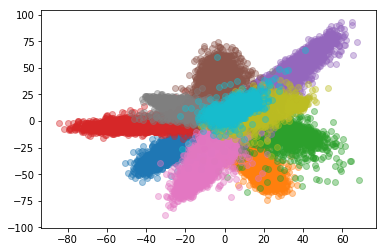

In [110]:
for data_by_class in class_data:
    data_by_class = np.array(data_by_class)
    plt.scatter(data_by_class[:, 0], data_by_class[:, 1], alpha=0.4)